In [28]:
import pandas as pd
import seaborn as sb

import matplotlib.pyplot as plt

In [35]:
train = pd.read_csv('./master.csv', sep=',')
train.rename(columns = {'country':'Country', 'year':'Year', 'sex': 'Sex',
                       'age':'Age', 'suicides_no': 'SuicidesNo',
                       'population': 'Population',
                       'suicides/100k pop' : 'Suicides100kPop',
                       'HDI for year': 'HDI',
                       ' gdp_for_year ($) ':'GDPYear',
                       'gdp_per_capita ($)': 'GDPpercapita',
                       'generation':'Generation'
                       }, inplace = True)

In [36]:
train.head(10)

,Country,Year,Sex,Age,SuicidesNo,Population,Suicides100kPop,country-year,HDI,GDPYear,GDPpercapita,Generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


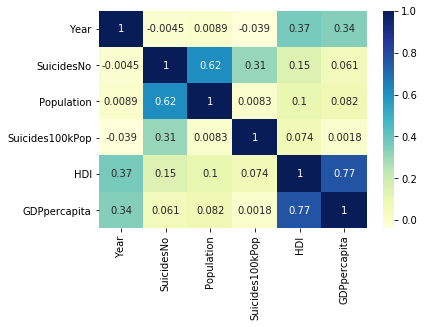

In [38]:
sb.heatmap(train.corr(),cmap='YlGnBu',annot=True)

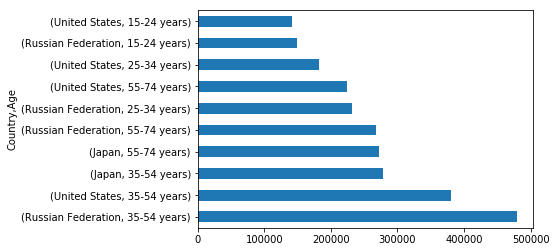

In [40]:
train.groupby(['Country','Age']).SuicidesNo.sum().nlargest(10).plot(kind='barh')

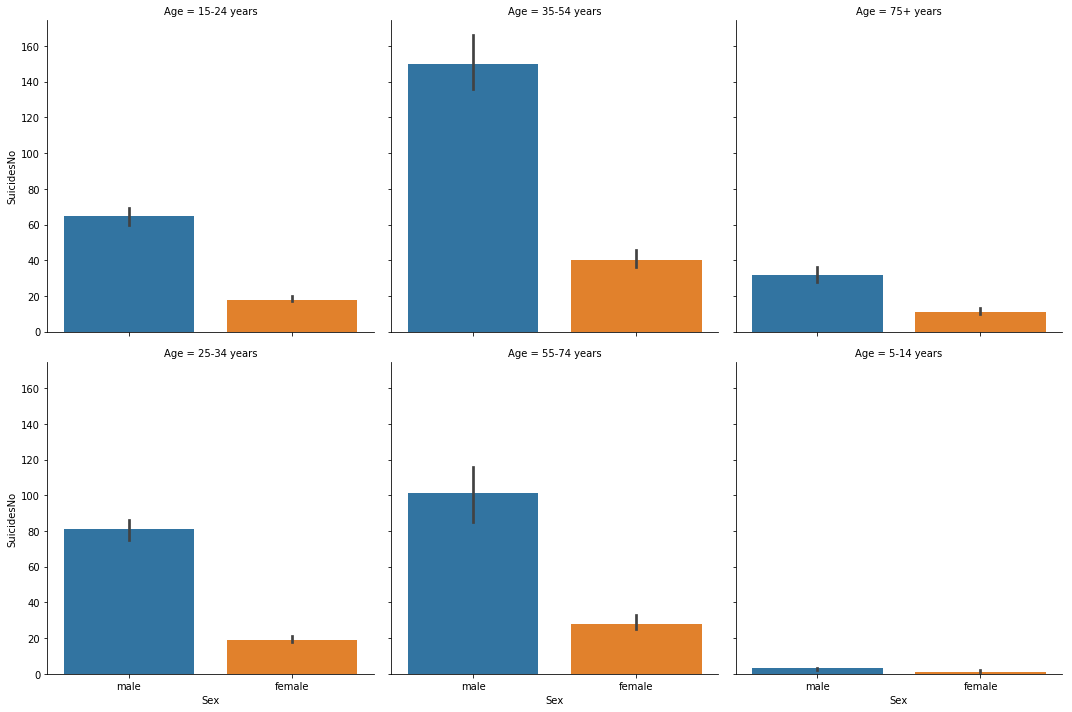

In [41]:
from numpy import median
sb.catplot(x="Sex", y="SuicidesNo",col='Age', data=train, 
                col_wrap = 3, estimator=median,kind='bar')

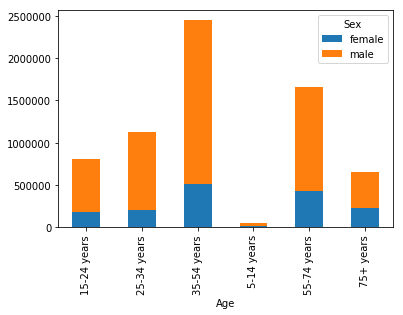

In [42]:
# train.groupby(by=['age','sex'])['suicides_no'].sum().unstack()
train.groupby(by=['Age','Sex'])['SuicidesNo'].sum().unstack().plot(kind='bar',stacked=True)

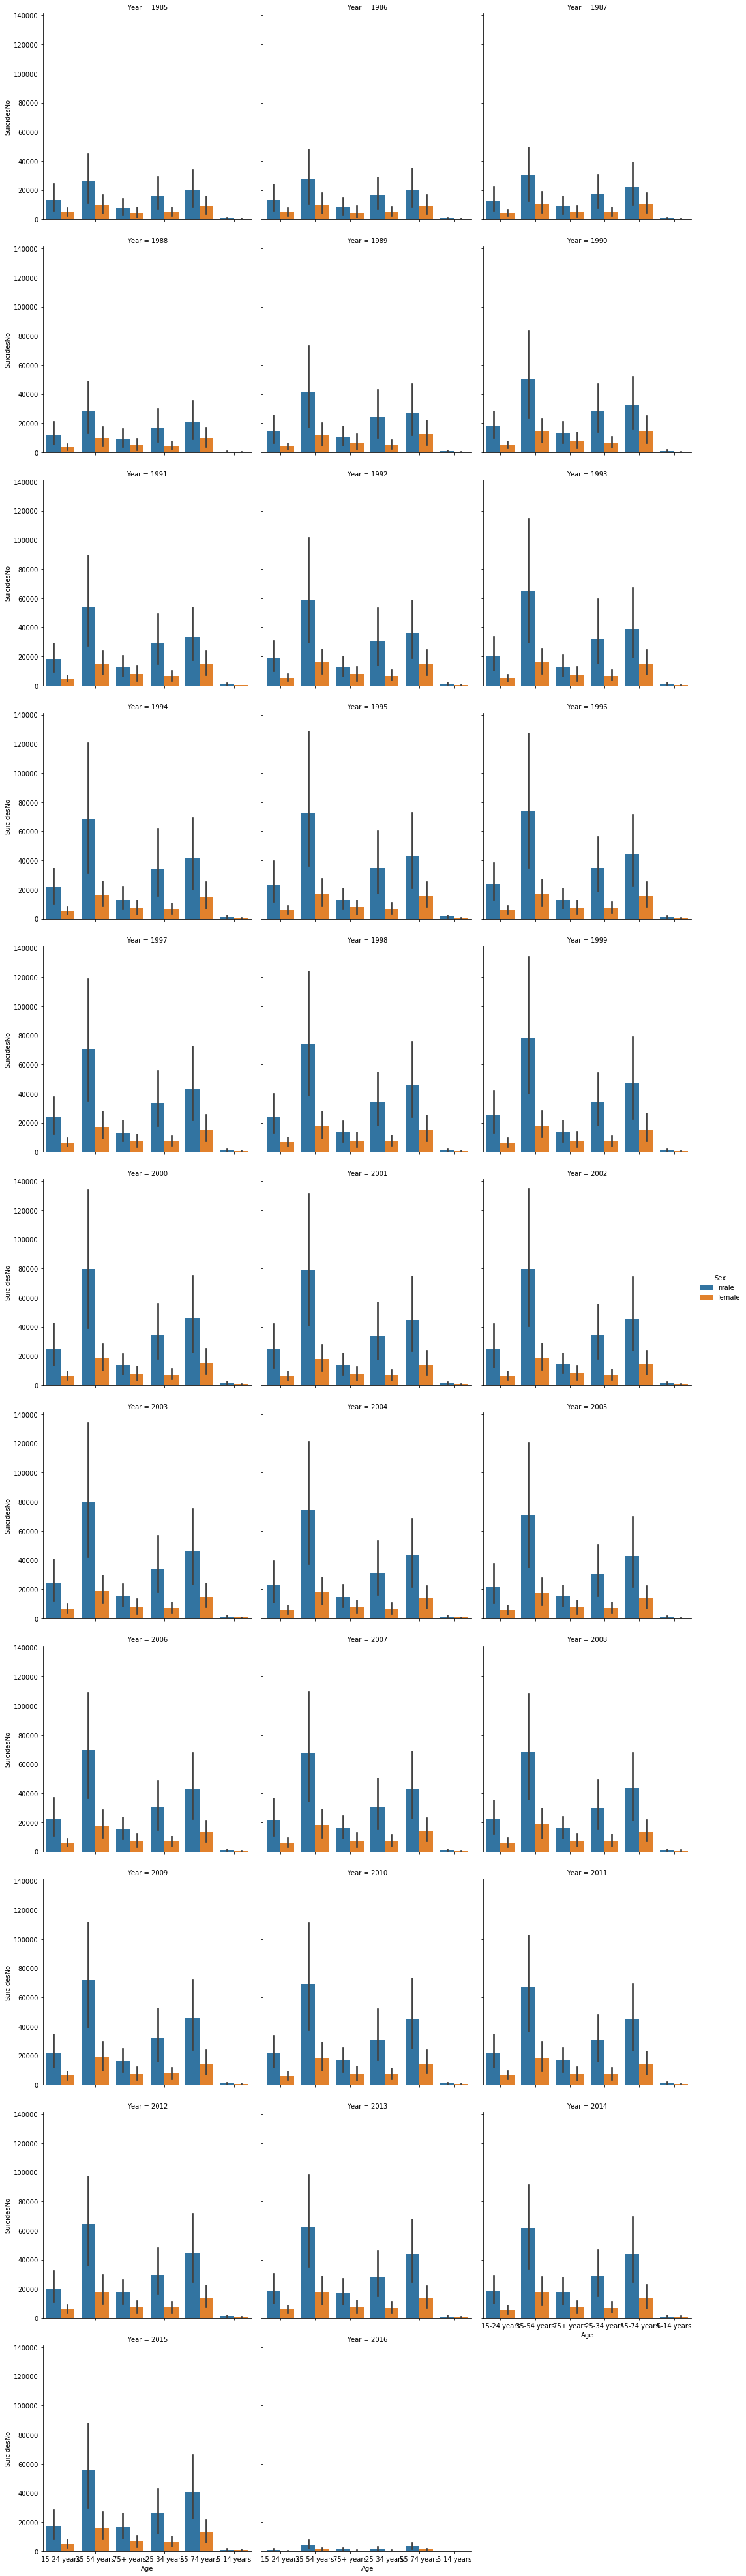

In [43]:
from numpy import sum
sb.catplot('Age','SuicidesNo',hue='Sex',col='Year',data=train,
           kind='bar',col_wrap=3,estimator=sum)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

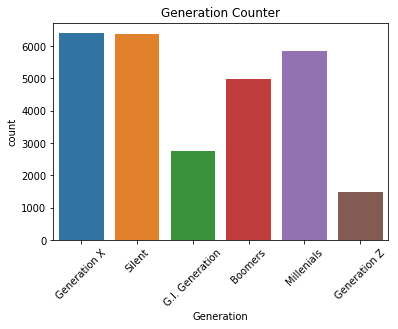

In [44]:
sb.countplot(train.Generation)
plt.title('Generation Counter')
plt.xticks(rotation=45)

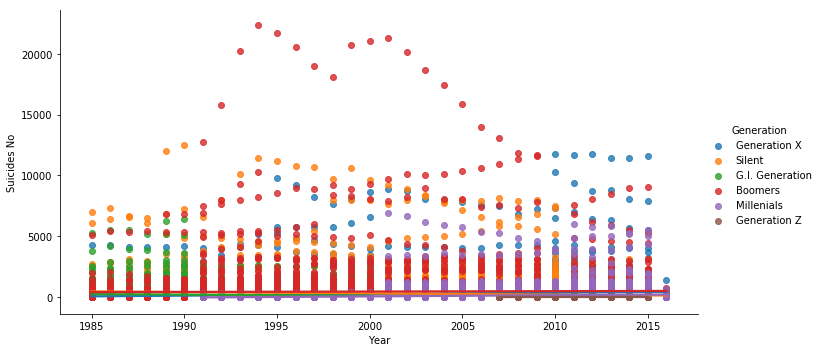

In [45]:
g = sb.lmplot(x="Year", y="SuicidesNo", hue="Generation",
               truncate=True, data=train, height = 5, aspect = 2)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Year", "Suicides No")
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 <a list of 32 Text xticklabel objects>)

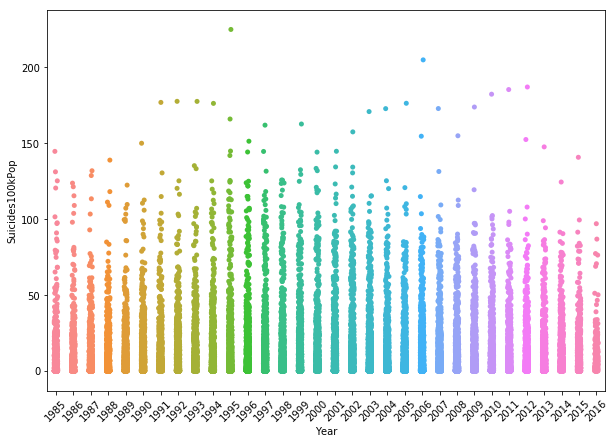

In [46]:
plt.figure(figsize=(10,7))
sb.stripplot(x="Year",y='Suicides100kPop',data=train)
plt.xticks(rotation=45)